In [1]:
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import mne

In [2]:
data_dir = 'data/sleep-cassette'

psg_files = sorted(glob(os.path.join(data_dir, '*PSG.edf')))
hypnogram_files = sorted(glob(os.path.join(data_dir, '*Hypnogram.edf')))

In [3]:
psg_files[:3]

['data/sleep-cassette/SC4001E0-PSG.edf',
 'data/sleep-cassette/SC4002E0-PSG.edf',
 'data/sleep-cassette/SC4011E0-PSG.edf']

In [4]:
hypnogram_files[:3]

['data/sleep-cassette/SC4001EC-Hypnogram.edf',
 'data/sleep-cassette/SC4002EC-Hypnogram.edf',
 'data/sleep-cassette/SC4011EH-Hypnogram.edf']

### Data Exploration

In [5]:
raw_edf = mne.io.read_raw_edf(psg_files[0], preload=True, verbose=False)

/tmp/ipykernel_3407283/468361730.py:1: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_edf = mne.io.read_raw_edf(psg_files[0], preload=True, verbose=False)
/tmp/ipykernel_3407283/468361730.py:1: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_edf = mne.io.read_raw_edf(psg_files[0], preload=True, verbose=False)
/tmp/ipykernel_3407283/468361730.py:1: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_edf = mne.io.read_raw_edf(psg_files[0], preload=True, verbose=False)


In [6]:
raw_edf

<RawEDF | SC4001E0-PSG.edf, 7 x 7950000 (79500.0 s), ~424.6 MiB, data loaded>

In [7]:
eeg_data = raw_edf.get_data()

In [8]:
eeg_data

array([[ 5.01684982e-06, -2.57875458e-06,  1.35970696e-06, ...,
         5.29816850e-06, -4.64175824e-06,  6.61098901e-06],
       [-2.46739927e-06,  1.46739927e-06, -4.09890110e-06, ...,
        -3.04322344e-06, -3.71501832e-06,  1.75531136e-06],
       [ 1.65086691e-05,  1.60158730e-05,  9.60952381e-06, ...,
         6.97306471e-05,  8.05721612e-05,  1.02255189e-04],
       ...,
       [ 3.55200000e-06,  3.55321564e-06,  3.55442478e-06, ...,
         3.54832977e-06,  3.54955549e-06,  3.55077942e-06],
       [ 3.72064516e+01,  3.72051596e+01,  3.72039072e+01, ...,
         3.72105629e+01,  3.72091535e+01,  3.72077830e+01],
       [ 9.20000000e+02,  9.19950203e+02,  9.19892908e+02, ...,
         9.20104028e+02,  9.20076946e+02,  9.20042260e+02]],
      shape=(7, 7950000))

In [9]:
eeg_channel1 = eeg_data[0]

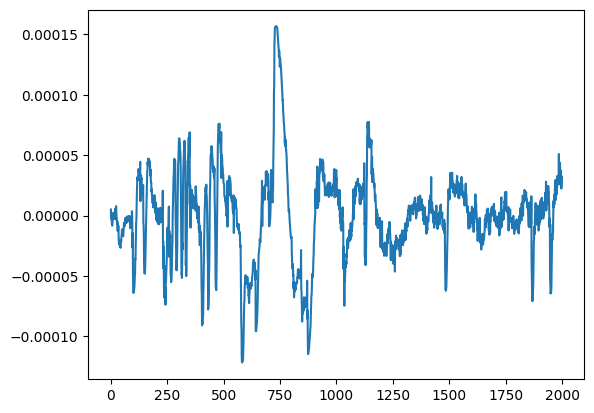

In [10]:
plt.plot(eeg_channel1[:2000])  # 20s

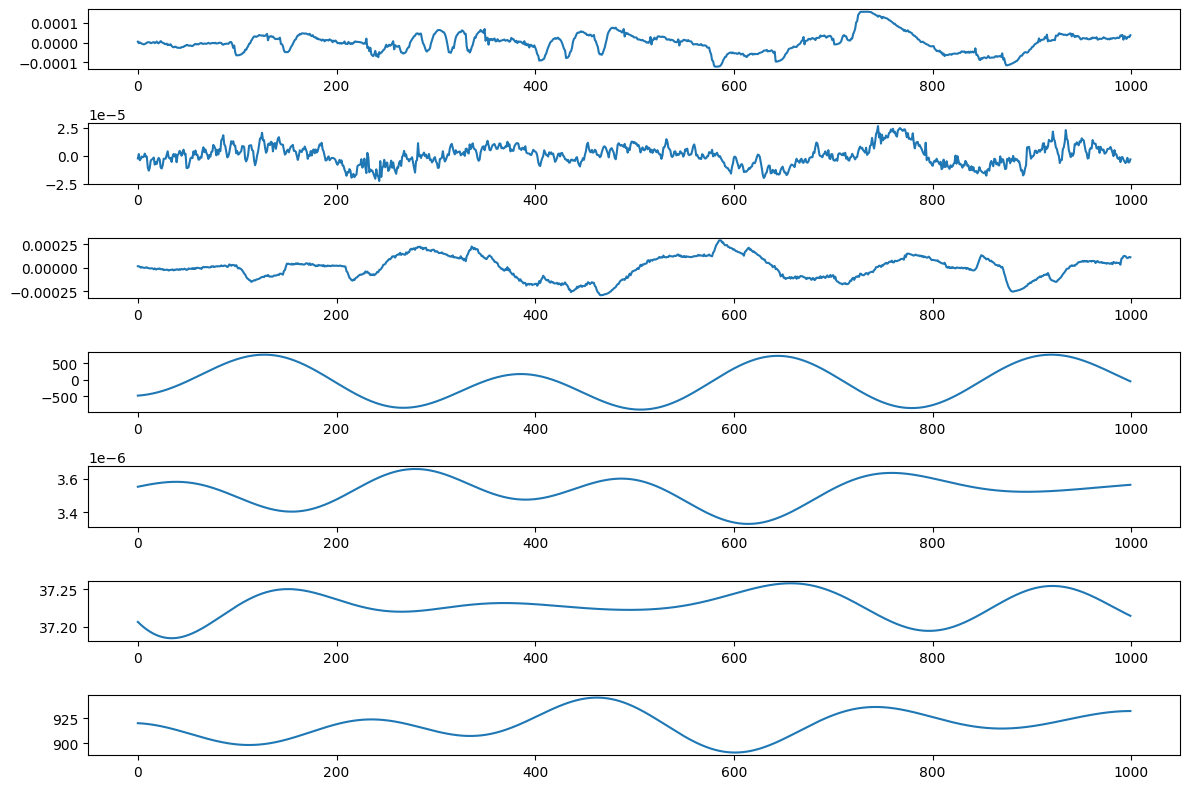

In [11]:
fig, axs = plt.subplots(nrows=7, ncols=1, figsize=(12,8))

for i, ax in enumerate(axs):
    ax.plot(eeg_data[i][:1000])

plt.tight_layout()

In [12]:
eeg_channels = ['EEG Fpz-Cz', 'EEG Pz-Oz']

eeg_data = raw_edf.get_data(picks=eeg_channels)

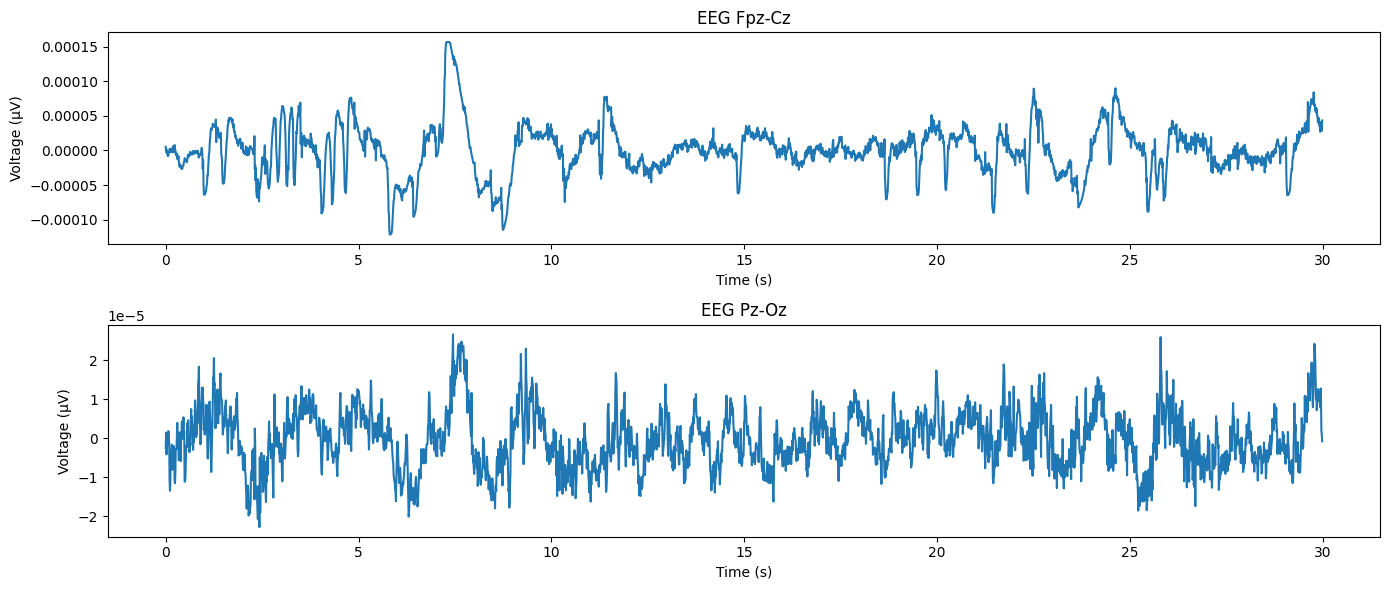

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 6))

fs = 100
N = 3000  # 30s

for i, ax in enumerate(axs):
    x = np.arange(N) / fs  # -> 0.01s

    ax.plot(x, eeg_data[i][:N])
    ax.set_title(eeg_channels[i])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Voltage (µV)')

plt.tight_layout()

In [14]:
annotations = mne.read_annotations(hypnogram_files[0])

In [15]:
annotations

<Annotations | 154 segments: Sleep stage 1 (24), Sleep stage 2 (40), Sleep ...>

In [16]:
annotations.onset

array([    0., 30630., 30750., 31140., 31170., 31200., 31350., 31380.,
       31440., 31500., 31530., 31650., 31680., 31800., 31830., 31890.,
       31950., 32070., 32100., 32130., 32250., 32460., 32490., 32550.,
       32670., 32700., 32850., 32910., 32940., 32970., 33000., 33120.,
       33270., 33300., 33330., 33390., 33420., 33510., 35400., 35430.,
       35640., 35700., 35790., 35940., 35970., 36840., 37020., 37260.,
       37290., 37410., 37500., 37530., 38460., 38490., 38520., 38580.,
       38610., 38640., 38670., 38700., 38730., 38760., 38910., 38970.,
       39060., 39120., 39150., 39180., 39240., 39300., 39480., 39540.,
       39570., 39600., 39870., 39900., 39960., 39990., 40200., 40230.,
       40290., 40320., 40500., 41370., 41400., 41460., 41490., 41610.,
       42480., 42510., 42540., 42570., 42870., 42900., 43290., 43320.,
       43350., 43380., 43410., 43590., 43680., 43710., 43920., 43980.,
       44010., 44040., 44220., 44280., 44340., 44400., 44520., 44640.,
      

In [17]:
annotations.duration

array([3.063e+04, 1.200e+02, 3.900e+02, 3.000e+01, 3.000e+01, 1.500e+02,
       3.000e+01, 6.000e+01, 6.000e+01, 3.000e+01, 1.200e+02, 3.000e+01,
       1.200e+02, 3.000e+01, 6.000e+01, 6.000e+01, 1.200e+02, 3.000e+01,
       3.000e+01, 1.200e+02, 2.100e+02, 3.000e+01, 6.000e+01, 1.200e+02,
       3.000e+01, 1.500e+02, 6.000e+01, 3.000e+01, 3.000e+01, 3.000e+01,
       1.200e+02, 1.500e+02, 3.000e+01, 3.000e+01, 6.000e+01, 3.000e+01,
       9.000e+01, 1.890e+03, 3.000e+01, 2.100e+02, 6.000e+01, 9.000e+01,
       1.500e+02, 3.000e+01, 8.700e+02, 1.800e+02, 2.400e+02, 3.000e+01,
       1.200e+02, 9.000e+01, 3.000e+01, 9.300e+02, 3.000e+01, 3.000e+01,
       6.000e+01, 3.000e+01, 3.000e+01, 3.000e+01, 3.000e+01, 3.000e+01,
       3.000e+01, 1.500e+02, 6.000e+01, 9.000e+01, 6.000e+01, 3.000e+01,
       3.000e+01, 6.000e+01, 6.000e+01, 1.800e+02, 6.000e+01, 3.000e+01,
       3.000e+01, 2.700e+02, 3.000e+01, 6.000e+01, 3.000e+01, 2.100e+02,
       3.000e+01, 6.000e+01, 3.000e+01, 1.800e+02, 

In [18]:
annotations.description

array(['Sleep stage W', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3',
       'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage 3',
       'Sleep stage 4', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage 3',
       'Sleep stage 4', 'Sleep stage W', 'Sleep stage 3', 'Sleep stage 2',
       'Sleep stage 3', 'Sleep stage 4', 'Sleep stage 3', 'Sleep stage 4',
       'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 2', 'Sleep stage 3',
       'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 2',
       'Sleep stage 3', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4',
       'Sleep stage 3', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4',
       'Sleep stage 3', 'Sleep stage 4', 'Sleep stage 1', 'Sleep stage 3',
       'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 2', 'Sleep stage 3',
       'Sleep stage R', 'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3',
       'Sleep stage 1', 'Sleep stage 2', 'Sleep stage 1', 'Sleep stage 2',
       'Sleep stage 3', '

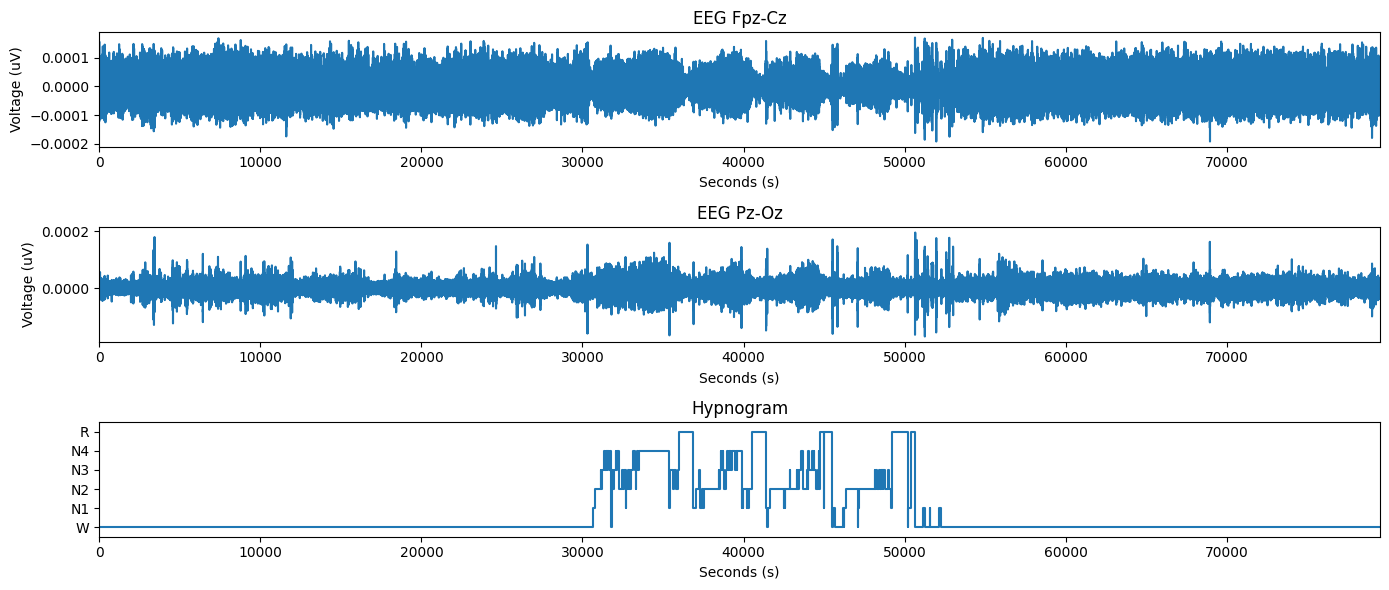

In [19]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(14,6))

fs = 100
N = 7950000

# Axis 1 - EEG
x = np.arange(N) / fs

axs[0].plot(x, eeg_data[0][:N])
axs[0].set_title(eeg_channels[0])
axs[0].set_xlabel('Seconds (s)')
axs[0].set_ylabel('Voltage (uV)')

axs[0].set_xlim(0, N/fs)

# Axis 2 - EEG
x = np.arange(N) / fs

axs[1].plot(x, eeg_data[1][:N])
axs[1].set_title(eeg_channels[1])
axs[1].set_xlabel('Seconds (s)')
axs[1].set_ylabel('Voltage (uV)')

axs[1].set_xlim(0, N/fs)

# Axis 3 - Hypnogram
t_end = N / fs

stage_map = {'Sleep stage W': 0, 'Sleep stage 1': 1, 'Sleep stage 2': 2, 'Sleep stage 3': 3, 'Sleep stage 4': 4, 'Sleep stage R': 5}

x, y = [], []
for o, d, s in zip(annotations.onset, annotations.duration, annotations.description):
    start, end = max(o, 0), min(o + d, t_end)
    stage = stage_map.get(s, np.nan)
    x += [start, end]
    y += [stage, stage]

axs[2].step(x, y, where='post')
axs[2].set_xlim(0, t_end)
axs[2].set_ylim(-0.5, 5.5)
axs[2].set_yticks([0,1,2,3,4,5])
axs[2].set_yticklabels(['W','N1','N2','N3', 'N4', 'R'])
axs[2].set_xlabel('Seconds (s)')
axs[2].set_title('Hypnogram')

plt.tight_layout()

### Data Preparation (Single Channel)

In [20]:
len(psg_files)

153

In [21]:
X_data = []
y_data = []
window_length = 3000  # 30s

for psg_file, hypnogram_file in zip(psg_files[:25], hypnogram_files[:25]):
    raw_edf = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
    eeg_channel1 = raw_edf.get_data(picks=['EEG Fpz-Cz'])[0]

    annotations = mne.read_annotations(hypnogram_file)

    stage_map = {'Sleep stage W': 0, 'Sleep stage 1': 1, 'Sleep stage 2': 2, 'Sleep stage 3': 3, 'Sleep stage 4': 4, 'Sleep stage R': 5}

    for i, (onset, duration, description) in enumerate(zip(annotations.onset, annotations.duration, annotations.description)):
        if description not in stage_map:
            continue

        for segment in range(int(onset * fs), int(onset * fs + duration * fs), window_length):
            start_sample = segment
            end_sample = segment + window_length

            if end_sample <= len(eeg_channel1):
                window = eeg_channel1[start_sample:end_sample]

                if len(window) == window_length:
                    X_data.append(window)
                    y_data.append(stage_map[description])


X = np.array(X_data)
y = np.array(y_data)

/tmp/ipykernel_3407283/1499770899.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_edf = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
/tmp/ipykernel_3407283/1499770899.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_edf = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
/tmp/ipykernel_3407283/1499770899.py:6: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_edf = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
/tmp/ipykernel_3407283/1499770899.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_edf = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
/tmp/ipykernel_3407283/1499770899.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be st

In [22]:
X.shape

(68180, 3000)

In [23]:
y.shape

(68180,)

In [24]:
np.bincount(y)

array([46546,  1950, 11566,  1948,  1504,  4666])

In [29]:
X = (X - X.mean()) / X.std()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [30]:
np.bincount(y_train) / len(y_train)

array([0.68269654, 0.02860076, 0.16964286, 0.0285641 , 0.02205559,
       0.06844016])

In [31]:
np.bincount(y_test) / len(y_test)

array([0.6826782 , 0.02860076, 0.16962452, 0.02860076, 0.02207392,
       0.06842182])

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.FloatTensor(X_train).unsqueeze(1).to(device)
X_test = torch.FloatTensor(X_test).unsqueeze(1).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

In [33]:
device

device(type='cuda')

### Model Training

In [34]:
model = nn.Sequential(
    nn.Conv1d(1, 32, kernel_size=50, stride=6),
    nn.ReLU(),
    nn.MaxPool1d(8),
    nn.Conv1d(32, 64, kernel_size=8),
    nn.ReLU(),
    nn.MaxPool1d(8),
    nn.Flatten(),
    nn.Linear(64 * 6, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 6)
).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [35]:
epochs = 10
batch_size = 64

for epoch in range(epochs):
    model.train()

    total_loss = 0

    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size].to(device)
        batch_y = y_train[i:i+batch_size].to(device)

        optimizer.zero_grad()

        outputs = model(batch_X)

        loss = criterion(outputs, batch_y)
        loss.backward()

        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(X_train):.4f}')

Epoch 1/10, Loss: 0.0067
Epoch 2/10, Loss: 0.0040
Epoch 3/10, Loss: 0.0036
Epoch 4/10, Loss: 0.0034
Epoch 5/10, Loss: 0.0033
Epoch 6/10, Loss: 0.0032
Epoch 7/10, Loss: 0.0030
Epoch 8/10, Loss: 0.0030
Epoch 9/10, Loss: 0.0029
Epoch 10/10, Loss: 0.0028


In [36]:
model.eval()

with torch.no_grad():
    predictions = model(X_test)
    predicted_classes = torch.argmax(predictions, dim=1).cpu().numpy()

accuracy = accuracy_score(y_test.cpu().numpy(), predicted_classes)

In [37]:
accuracy

0.923657964212379

In [38]:
confusion_matrix(y_test.cpu().numpy(), predicted_classes)

array([[9268,   11,   10,    1,    2,   17],
       [ 127,   61,   65,    0,    1,  136],
       [  38,   19, 1956,  137,    2,  161],
       [   2,    0,   18,  253,  117,    0],
       [   2,    0,    0,   18,  281,    0],
       [  37,   39,   81,    0,    0,  776]])

In [39]:
accuracy

0.923657964212379

In [40]:
confusion_matrix(y_test.cpu().numpy(), predicted_classes)

array([[9268,   11,   10,    1,    2,   17],
       [ 127,   61,   65,    0,    1,  136],
       [  38,   19, 1956,  137,    2,  161],
       [   2,    0,   18,  253,  117,    0],
       [   2,    0,    0,   18,  281,    0],
       [  37,   39,   81,    0,    0,  776]])

### Data Preparation (Both Channels)

In [41]:
len(psg_files)

153

In [42]:
X_data = []
y_data = []
window_length = 3000  # 30s

for psg_file, hypnogram_file in zip(psg_files[:25], hypnogram_files[:25]):
    raw_edf = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
    eeg_channel1 = raw_edf.get_data(picks=['EEG Fpz-Cz'])[0]
    eeg_channel2 = raw_edf.get_data(picks=['EEG Pz-Oz'])[0]

    annotations = mne.read_annotations(hypnogram_file)

    stage_map = {'Sleep stage W': 0, 'Sleep stage 1': 1, 'Sleep stage 2': 2, 'Sleep stage 3': 3, 'Sleep stage 4': 4, 'Sleep stage R': 5}

    for i, (onset, duration, description) in enumerate(zip(annotations.onset, annotations.duration, annotations.description)):
        if description not in stage_map:
            continue

        for segment in range(int(onset * fs), int(onset * fs + duration * fs), window_length):
            start_sample = segment
            end_sample = segment + window_length

            if end_sample <= len(eeg_channel1):
                window1 = eeg_channel1[start_sample:end_sample]
                window2 = eeg_channel2[start_sample:end_sample]

                if len(window1) == window_length:
                    X_data.append(np.stack([window1, window2], axis=0))
                    y_data.append(stage_map[description])


X = np.array(X_data)
y = np.array(y_data)

/tmp/ipykernel_3407283/4206200601.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_edf = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
/tmp/ipykernel_3407283/4206200601.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw_edf = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
/tmp/ipykernel_3407283/4206200601.py:6: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw_edf = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
/tmp/ipykernel_3407283/4206200601.py:6: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw_edf = mne.io.read_raw_edf(psg_file, preload=True, verbose=False)
/tmp/ipykernel_3407283/4206200601.py:6: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be st

In [43]:
X.shape

(68180, 2, 3000)

In [44]:
y.shape

(68180,)

In [45]:
np.bincount(y)

array([46546,  1950, 11566,  1948,  1504,  4666])

In [46]:
X = (X - X.mean()) / X.std()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [47]:
np.bincount(y_train) / len(y_train)

array([0.68269654, 0.02860076, 0.16964286, 0.0285641 , 0.02205559,
       0.06844016])

In [48]:
np.bincount(y_test) / len(y_test)

array([0.6826782 , 0.02860076, 0.16962452, 0.02860076, 0.02207392,
       0.06842182])

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

In [50]:
device

device(type='cuda')

### Model Training

In [51]:
model = nn.Sequential(
    nn.Conv1d(2, 32, kernel_size=50, stride=6),
    nn.ReLU(),
    nn.MaxPool1d(8),
    nn.Conv1d(32, 64, kernel_size=8),
    nn.ReLU(),
    nn.MaxPool1d(8),
    nn.Flatten(),
    nn.Linear(64 * 6, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 6)
).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [52]:
epochs = 10
batch_size = 64

for epoch in range(epochs):
    model.train()

    total_loss = 0

    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size].to(device)
        batch_y = y_train[i:i+batch_size].to(device)

        optimizer.zero_grad()

        outputs = model(batch_X)

        loss = criterion(outputs, batch_y)
        loss.backward()

        optimizer.step()
        total_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(X_train):.4f}')

Epoch 1/10, Loss: 0.0057
Epoch 2/10, Loss: 0.0036
Epoch 3/10, Loss: 0.0032
Epoch 4/10, Loss: 0.0030
Epoch 5/10, Loss: 0.0029
Epoch 6/10, Loss: 0.0028
Epoch 7/10, Loss: 0.0027
Epoch 8/10, Loss: 0.0026
Epoch 9/10, Loss: 0.0025
Epoch 10/10, Loss: 0.0025


In [53]:
model.eval()

with torch.no_grad():
    predictions = model(X_test)
    predicted_classes = torch.argmax(predictions, dim=1).cpu().numpy()

accuracy = accuracy_score(y_test.cpu().numpy(), predicted_classes)

In [54]:
accuracy

0.9366383103549428

In [55]:
confusion_matrix(y_test.cpu().numpy(), predicted_classes)

array([[9276,   17,   11,    0,    0,    5],
       [ 106,   98,   90,    2,    0,   94],
       [  16,   22, 2109,  101,    0,   65],
       [   4,    0,   57,  301,   27,    1],
       [   4,    0,    1,   72,  224,    0],
       [  35,   39,   95,    0,    0,  764]])

In [56]:
accuracy

0.9366383103549428

In [57]:
confusion_matrix(y_test.cpu().numpy(), predicted_classes)

array([[9276,   17,   11,    0,    0,    5],
       [ 106,   98,   90,    2,    0,   94],
       [  16,   22, 2109,  101,    0,   65],
       [   4,    0,   57,  301,   27,    1],
       [   4,    0,    1,   72,  224,    0],
       [  35,   39,   95,    0,    0,  764]])